# Pylops - CUDA basic linear operators

### Author: M.Ravasi

In this notebook we will experiment with Pytorch to assess its usability as backend for CUDA enabled operators

In [1]:
!pip install pylops
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-isos42nz
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-isos42nz
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8lxdp1j/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
Successfully built pylops-gpu


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt

import pylops
from pylops import Diagonal
from pylops.utils import dottest
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

PyLops-gpu working on cuda...


## Diagonal

Example with model and data already on GPU

In [4]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev)
dottest(Dop, n, n, verb=True)
gdottest(Dop_gpu, n, n, device=dev, verb=True)

# y = Dx
yg = Dop_gpu * xg
print('y', yg)

Dot test passed, v^T(Opu)=-70078240.739681 - u^T(Op^Tv)=-70078240.739680
Dot test passed, v^T(Opu)=124843622400.000000 - u^T(Op^Tv)=124843622400.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


In [5]:
%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xg

10 loops, best of 3: 853 µs per loop
10 loops, best of 3: 15.5 µs per loop


Example with model and data transfered from and to gpu in forward and adjoint operations

Dot test passed, v^T(Opu)=125046120448.000000 - u^T(Op^Tv)=125046120448.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


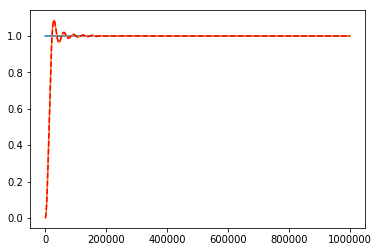

In [6]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

xc = xg.cpu()
x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))
gdottest(Dop_gpu, n, n, verb=True)

# y = Dx
y = Dop_gpu * x
print('y', yg)

# xinv = D^-1 y
xinv = Dop / y
xinvg = Dop_gpu / y

plt.figure()
plt.plot(x)
plt.plot(xinv)
plt.plot(xinvg, '--r')

In [7]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 711 µs per loop
10 loops, best of 3: 943 µs per loop


In [8]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 760 µs per loop
10 loops, best of 3: 2.39 ms per loop


Note here how we get hit by the cost of moving x and y back and forth between CPU and GPU.

# 1D Convolution

In [9]:
N = 11
Nh = 3
x = np.zeros(N)
x[N//2] = 1

h = np.arange(Nh)+1
y = np.convolve(x, h, mode='same')
print(y)
print(y.shape)

[0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
(11,)


In [10]:
xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [11]:
y = np.correlate(x, h, mode='same')
print(y)

yt = torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

[0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0.]
tensor([[[0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [14]:
xt = torch.zeros((1000, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([1000, 1, 11])
torch.Size([1000, 1, 11])
1000 loops, best of 3: 423 µs per loop
The slowest run took 14.42 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 40.4 µs per loop
